<a href="https://colab.research.google.com/github/MarcoZanine/2025_ML_EES/blob/main/FinalProject/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Final Project

A regression model for piezometric level prediction




## Initial Setup and Data Loading

### Subtask:
Consolidate cells for mounting Google Drive, listing files, and loading the initial piezometric and correspondence tables into DataFrames (`piezo` and `corres`). Ensure all necessary imports are at the top.


**Reasoning**:
Consolidate the Drive mounting, file listing, and initial data loading operations into a single code block as per the subtask instructions. This includes importing necessary libraries and loading the `corres` and `piezo` DataFrames.



In [1]:
import pandas as pd
from google.colab import drive
import os

drive.mount('/content/drive')

# Dossier où tu as mis tes fichiers Excel sur Drive
base_path = "/content/drive/MyDrive/Colab Notebooks/"   # <-- adapte le nom du dossier

print("Files in Colab Notebooks folder:")
print(os.listdir(base_path))

corres = pd.read_excel(os.path.join(base_path, 'Tableau_meteo.xlsx'))
piezo = pd.read_excel(os.path.join(base_path, 'CSV_combined_long.xlsx'))

print("\n'corres' DataFrame loaded successfully. Head of 'corres':")
print(corres.head())
print("\n'piezo' DataFrame loaded successfully. Head of 'piezo':")
print(piezo.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in Colab Notebooks folder:
['Untitled0.ipynb', 'Copie de Week1_0_Variables_Operators.ipynb', 'Copie de W1_S1.ipynb', 'Untitled1.ipynb', 'CSV_combined_long.xlsx', 'Untitled2.ipynb', 'Tableau_meteo.xlsx', 'Untitled', 'FinalProject.ipynb', 'piezo_plus_meteo.xlsx']

'corres' DataFrame loaded successfully. Head of 'corres':
                  station_piezo Kanton  Koordinaten  Unnamed: 3  altitude  \
0           Altdorf-Zwyermattth     UR    2691655.0   1192007.0    465.92   
1     Baar-WeidhofWeststrasseth     ZG    2681605.0   1227651.0    432.16   
2  Basel-Merian-Iselin-Klinikth     BS    2609900.0   1267200.0    277.45   
3          Bettwil-Moosmattenth     AG    2662689.0   1237465.0    687.00   
4           Böckten-Bruggmattth     BL    2629280.0   1256847.0    381.50   

     station_meteo station_abbr  \
0          Altdorf          ALT   
1          

## Data Cleaning and Merging

### Subtask:
Combine the existing steps for cleaning and merging the piezometric and meteorological data. This includes fetching meteo data from URLs, standardizing timestamps, cleaning station names, merging with the correspondence table to add altitude, and performing the final merge to create `piezo_full`. This section will culminate in the creation of a clean `piezo_full` DataFrame.


**Reasoning**:
The subtask requires combining several existing steps for data cleaning and merging into a single code block, including fetching meteorological data, standardizing timestamps, cleaning station names, merging with the correspondence table, and removing duplicates, culminating in the creation of `piezo_full` and its export. I will consolidate the code from the existing notebook cell `Vq66H0Dffg6b` to achieve this.



In [2]:
import requests
import io
import pandas as pd

# Colonnes météo à garder
colonnes_utiles = [
    "reference_timestamp",
    "station_abbr",
    "tre200m0",
    "rre150m0",
    "ure200m0",
    "rreetsm0"
]

# 1. Rename the column altitude
corres = corres.rename(columns={
    "OK Terrain (m ü.M.)": "altitude"
})

# 2. Initialize an empty list named dfs
dfs = []

# 3. Loop through each row of the corres DataFrame.
for idx, row in corres.iterrows():
    # 4. Inside the loop, extract the URL and 'station_abbr' from the current row.
    url = row["url"]
    station_abbr = row["station_abbr"]

    # 5. Make an HTTP GET request to the extracted URL and read the content as a CSV into a pandas DataFrame.
    r = requests.get(url)
    df_meteo = pd.read_csv(io.BytesIO(r.content), sep=None, engine="python")

    # 6. Convert all column names in the newly created DataFrame to lowercase.
    df_meteo.columns = df_meteo.columns.str.lower()

    # 7. Convert the 'reference_timestamp' column to datetime objects, handling errors by coercing them, and then standardize these timestamps to the first day of their respective month.
    df_meteo["reference_timestamp"] = pd.to_datetime(
        df_meteo["reference_timestamp"],
        dayfirst=True,
        errors="coerce"
    )
    df_meteo["reference_timestamp"] = df_meteo["reference_timestamp"].dt.to_period("M").dt.to_timestamp()

    # 8. Add the 'station_abbr' from the corres DataFrame as a new column to the current meteorological DataFrame.
    df_meteo["station_abbr"] = station_abbr

    # 9. Filter the meteorological DataFrame to keep only the predefined useful columns.
    cols_presentes = [c for c in colonnes_utiles if c in df_meteo.columns]
    df_meteo = df_meteo[cols_presentes]

    # 10. Append the processed meteorological DataFrame to the dfs list.
    dfs.append(df_meteo)

# 11. After the loop, concatenate all DataFrames in the dfs list into a single DataFrame named meteo_all.
meteo_all = pd.concat(dfs, ignore_index=True)

# 12. Filter meteo_all to retain only records with 'reference_timestamp' between '1995-01-01' and '2025-01-01'.
piezo_min = pd.to_datetime("1995-01-01")
piezo_max = pd.to_datetime("2025-01-01")
meteo_all = meteo_all[
    (meteo_all["reference_timestamp"] >= piezo_min) &
    (meteo_all["reference_timestamp"] <= piezo_max)
]

# 13. Clean the 'station_piezo' column in the piezo DataFrame by removing the prefix 'niveau_a.s.m_'.
piezo["station_piezo"] = piezo["station_piezo"].str.replace(
    "niveau_a.s.m_", "",
    regex=False
)

# 14. Convert the 'reference_timestamp' column in the piezo DataFrame to datetime objects, handling errors.
piezo["reference_timestamp"] = pd.to_datetime(
    piezo["reference_timestamp"],
    dayfirst=True,
    errors="coerce"
)

# 15. Extract the 'year' and 'month' components from the 'reference_timestamp' in the piezo DataFrame and store them in new columns.
piezo["year"] = piezo["reference_timestamp"].dt.year
piezo["month"] = piezo["reference_timestamp"].dt.month

# 16. Merge the piezo DataFrame with a subset of the corres DataFrame (containing 'station_piezo', 'station_meteo', 'station_abbr', 'altitude') using a left merge on 'station_piezo'.
piezo = piezo.merge(
    corres[["station_piezo", "station_meteo", "station_abbr", "altitude"]],
    on="station_piezo",
    how="left"
)

# 17. Perform a left merge of the updated piezo DataFrame with meteo_all on 'station_abbr' and 'reference_timestamp', storing the result in piezo_full.
piezo_full = piezo.merge(
    meteo_all,
    on=["station_abbr", "reference_timestamp"],
    how="left"
)

# 18. Remove duplicate rows from piezo_full based on the combination of 'station_piezo', 'year', and 'month', keeping the first occurrence.
piezo_full = piezo_full.drop_duplicates(
    subset=["station_piezo", "year", "month"],
    keep="first"
)

# 19. Export the final piezo_full DataFrame to an Excel file named 'piezo_plus_meteo.xlsx' in the specified base_path without including the index.
output_path = base_path + "piezo_plus_meteo.xlsx"
piezo_full.to_excel(output_path, index=False)

print("Data cleaning and merging completed. First 5 rows of piezo_full:")
print(piezo_full.head())
print(f"Shape of piezo_full: {piezo_full.shape}")
print(f"Exported to: {output_path}")

Data cleaning and merging completed. First 5 rows of piezo_full:
  reference_timestamp        station_piezo  niveau_piezo  year  month  \
0          1995-01-01  Altdorf-Zwyermattth        443.56  1995      1   
2          1995-02-01  Altdorf-Zwyermattth        443.58  1995      2   
4          1995-03-01  Altdorf-Zwyermattth        443.43  1995      3   
6          1995-04-01  Altdorf-Zwyermattth        443.87  1995      4   
8          1995-05-01  Altdorf-Zwyermattth        444.00  1995      5   

  station_meteo station_abbr  altitude  tre200m0  rre150m0  ure200m0  rreetsm0  
0       Altdorf          ALT    465.92       0.8     161.9      76.0     167.3  
2       Altdorf          ALT    465.92       4.9      96.8      78.5      92.2  
4       Altdorf          ALT    465.92       3.9     107.4      68.9      78.5  
6       Altdorf          ALT    465.92       9.5     145.0      69.5     111.4  
8       Altdorf          ALT    465.92      13.5     114.1      67.7      38.5  
Shape of p

## NaN Analysis and Station Filtering

### Subtask:
Apply the NaN analysis to `piezo_full` to identify and filter out stations with a high proportion of missing values. This step ensures that only stations with sufficient data quality are used for modeling.


**Reasoning**:
The subtask requires applying NaN analysis to `piezo_full`, identifying and filtering out stations with high proportions of missing values. This involves copying the DataFrame, defining analysis columns, calculating missing value percentages per station, setting a threshold, and then filtering the DataFrame based on valid stations. This directly corresponds to the logic in the provided notebook cell `_cSke-uR5lUB`.



In [3]:
df = piezo_full.copy()

colonnes_analyse = ["niveau_piezo", "tre200m0", "rre150m0", "ure200m0", "rreetsm0"]

nan_table = df.groupby("station_piezo")[colonnes_analyse].apply(lambda g: g.isna().mean())

seuil = 0.20
stations_valides = nan_table[nan_table.max(axis=1) < seuil].index
stations_invalides = nan_table[nan_table.max(axis=1) >= seuil].index

print("Stations conservées :", len(stations_valides))
print("Stations exclues :", len(stations_invalides))

df = df[df["station_piezo"].isin(stations_valides)]

print("NaN analysis and station filtering complete. The 'df' DataFrame now contains only valid stations.")
print(f"New shape of 'df': {df.shape}")

Stations conservées : 22
Stations exclues : 29
NaN analysis and station filtering complete. The 'df' DataFrame now contains only valid stations.
New shape of 'df': (7942, 12)


## Data Splitting (Spatial and Temporal)

### Subtask:
Perform the spatial split of stations into training, validation, and test sets. Then, apply this split to create `train_df`, `val_df`, and `test_df`. Clearly explain the rationale for spatial splitting.


**Reasoning**:
To perform the spatial splitting as per the subtask, I will extract unique station names, shuffle them, divide them into train, validation, and test sets based on proportions, and then create the corresponding DataFrames. This reuses and adapts the logic from the previous notebook cell `SsyN9tC7AtYk`.



In [4]:
import numpy as np

# 1. Extract all unique station names from the `df` DataFrame.
stations = df["station_piezo"].unique()

# 2. Set a random seed for reproducibility and shuffle the list of unique station names.
np.random.seed(42)
np.random.shuffle(stations)

# 3. Define the proportions for the test and validation sets
n_test = int(0.20 * len(stations))
n_val  = int(0.20 * len(stations))

# 4. Divide the shuffled station names into three lists
stations_test = stations[:n_test]
stations_val  = stations[n_test:n_test+n_val]
stations_train = stations[n_test+n_val:]

# 5. Print the number of stations in each set.
print("Stations train :", len(stations_train))
print("Stations val   :", len(stations_val))
print("Stations test  :", len(stations_test))

# 6. Create train_df, val_df, and test_df by filtering the main df DataFrame
train_df = df[df["station_piezo"].isin(stations_train)].copy()
val_df   = df[df["station_piezo"].isin(stations_val)].copy()
test_df  = df[df["station_piezo"].isin(stations_test)].copy()

print("Spatial splitting complete. DataFrames train_df, val_df, and test_df created.")

Stations train : 14
Stations val   : 4
Stations test  : 4
Spatial splitting complete. DataFrames train_df, val_df, and test_df created.


### Rationale for Spatial Splitting

Spatial splitting is crucial for robust model evaluation, especially in contexts like piezometric level prediction where geographic location can introduce significant variations in data characteristics (e.g., mean levels, seasonal patterns).

By splitting stations into distinct train, validation, and test sets, we ensure that the model is evaluated on stations it has *never seen* during training or hyperparameter tuning. This setup provides a more realistic assessment of the model's ability to generalize to new, geographically distinct locations. If we were to perform a random, temporal, or shuffled split across all data points (without considering station identity), the model might "memorize" patterns specific to certain stations present in both training and test sets, leading to an overly optimistic performance estimate.

Therefore, spatial splitting helps us understand how well our model can predict piezometric levels at new monitoring stations, which is a key requirement for real-world applicability.

## Lag Feature Selection and Imputation

### Subtask:
First, calculate the AutoCorrelation Function (ACF) on the training data to select appropriate lag values for `niveau_piezo`. Then, apply `IterativeImputer` separately to `train_df`, `val_df`, and `test_df` to handle any remaining missing values.


**Reasoning**:
I will calculate the AutoCorrelation Function (ACF) for 'niveau_piezo' for each station in the training data, compute the mean ACF, and identify significant lag values based on a threshold of 0.5, as per the first three instructions.



In [5]:
import statsmodels.api as sm
import numpy as np

acf_vals = []
for st, grp in train_df.groupby("station_piezo"):
    ts = grp["niveau_piezo"].dropna()
    if len(ts) > 24:
        acf_vals.append(sm.tsa.acf(ts, nlags=12, fft=True))

acf_mean = np.nanmean(acf_vals, axis=0)
lags = [lag for lag, corr in enumerate(acf_mean) if lag > 0 and corr > 0.5]

print("Lags retenus :", lags)


Lags retenus : [1, 2]


**Reasoning**:
Now that the lag values have been identified, I will proceed with the imputation step. This involves defining the columns for imputation, creating the `impute_iter` function as specified, and then applying this function to the training, validation, and test dataframes (`train_df`, `val_df`, `test_df`) to handle missing values, resulting in `train_imp`, `val_imp`, and `test_imp`.



In [6]:
# ==========================================
# CELLULE 4 — Imputation séparée train / val / test
# ==========================================

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

colonnes_meteo = ["tre200m0", "rre150m0", "ure200m0", "rreetsm0"]
colonnes_imputation = ["niveau_piezo"] + colonnes_meteo

def impute_iter(df_split):
    df_out = []
    for st, grp in df_split.groupby("station_piezo"):
        grp = grp.sort_values("reference_timestamp").copy()
        available = [c for c in colonnes_imputation if c in grp.columns]

        imp = IterativeImputer(max_iter=20, random_state=0)
        grp[available] = imp.fit_transform(grp[available])

        df_out.append(grp)

    return pd.concat(df_out).sort_values(["station_piezo","reference_timestamp"])

train_imp = impute_iter(train_df)
val_imp   = impute_iter(val_df)
test_imp  = impute_iter(test_df)

print("Imputation completed for train, validation, and test datasets.")

Imputation completed for train, validation, and test datasets.


## Feature Engineering (Lags, Time Features, Baselines)

### Subtask:
Create lagged features (`niveau_lag1`, `niveau_lag2`) based on the selected lags. Generate cyclic time features (`month_sin`, `month_cos`). Finally, calculate baseline predictions (persistence and climatology) for comparison.


**Reasoning**:
I will apply the `apply_lags`, `add_time_features`, and `make_baselines` functions sequentially to the respective dataframes, creating lagged features, cyclic time features, and baseline predictions as per the subtask instructions.



In [7]:
# ==========================================
# CELLULE 6 — Création des lags APRÈS imputation
# ==========================================

def apply_lags(df_in, lags):
    df = df_in.copy()
    df = df.sort_values(["station_piezo", "reference_timestamp"])

    for lag in lags:
        df[f"niveau_lag{lag}"] = df.groupby("station_piezo")["niveau_piezo"].shift(lag)

    return df

train_lag = apply_lags(train_imp, lags).dropna()
val_lag   = apply_lags(val_imp,   lags).dropna()
test_lag  = apply_lags(test_imp,  lags).dropna()

lag_cols = [f"niveau_lag{lag}" for lag in lags]
print("Colonnes lags :", lag_cols)

# ==========================================
# CELLULE 7 — Ajout des variables temporelles
# ==========================================

def add_time_features(df):
    df = df.copy()
    df["month"] = df["reference_timestamp"].dt.month
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df

train_time = add_time_features(train_lag)
val_time   = add_time_features(val_lag)
test_time  = add_time_features(test_lag)

print("Time features added to train_time, val_time, and test_time.")

# ==========================================
# CELLULE 8 — Baselines
# ==========================================
def make_baselines(df_in):
    df = df_in.copy()

    df["baseline_persistence"] = df.groupby("station_piezo")["niveau_piezo"].shift(1)

    clim = df.groupby(["station_piezo", "month"])["niveau_piezo"].mean().rename("baseline_climatology")
    df = df.join(clim, on=["station_piezo", "month"])

    return df

train_bl = make_baselines(train_time)
val_bl   = make_baselines(val_time)
test_bl  = make_baselines(test_time)

print("Baselines calculated for train_bl, val_bl, and test_bl.")

Colonnes lags : ['niveau_lag1', 'niveau_lag2']
Time features added to train_time, val_time, and test_time.
Baselines calculated for train_bl, val_bl, and test_bl.


## Revised Scaling and Target Definition

### Subtask:
Implement the revised scaling strategy: apply RobustScaler only to non-piezometric features (`tre200m0`, `rre150m0`, etc., and `altitude`, `month_sin`, `month_cos`), fitting it *only* on the training data. The target variable (`niveau_piezo`) and its lags will remain unscaled. Crucially, define the new target variable as the *difference* from the previous month's piezometric level (`niveau_piezo_diff = niveau_piezo - niveau_lag1`).


**Reasoning**:
I will implement the revised scaling strategy by separating features to be scaled from those that remain raw, then define the new target variable as the difference from the previous month's piezometric level, and finally prepare the new feature and target splits for modeling, as per the instructions.



In [8]:
from sklearn.preprocessing import RobustScaler

# 1. Define a list named features_to_scale
features_to_scale = [
    "tre200m0", "rre150m0", "ure200m0", "rreetsm0",
    "altitude", "month_sin", "month_cos"
]

# Features that should NOT be scaled (target and its lags, which are already in raw units)
features_to_keep_raw = ["niveau_piezo"] + lag_cols

# Initialize DataFrames for normalized data by copying the original 'time' DataFrames
train_norm = train_time.copy()
val_norm   = val_time.copy()
test_norm  = test_time.copy()

# 2. Initialize a RobustScaler object.
global_scaler = RobustScaler()

# 3. Fit the RobustScaler on the train_time DataFrame, using only the columns specified in features_to_scale.
global_scaler.fit(train_time[features_to_scale])

# 4. Apply the fitted RobustScaler to transform the features_to_scale columns in train_time, val_time, and test_time.
# Ensure that niveau_piezo and its lag features are copied directly from the _time DataFrames to the _norm DataFrames without scaling.
# (This is handled by copying the original dataframes and then selectively transforming 'features_to_scale')
train_norm[features_to_scale] = global_scaler.transform(train_time[features_to_scale])
val_norm[features_to_scale]   = global_scaler.transform(val_time[features_to_scale])
test_norm[features_to_scale]  = global_scaler.transform(test_time[features_to_scale])

# 5. Create a new column named "niveau_piezo_diff" in train_norm, val_norm, and test_norm
train_norm["niveau_piezo_diff"] = train_norm["niveau_piezo"] - train_norm["niveau_lag1"]
val_norm["niveau_piezo_diff"]   = val_norm["niveau_piezo"]   - val_norm["niveau_lag1"]
test_norm["niveau_piezo_diff"]  = test_norm["niveau_piezo"]  - test_norm["niveau_lag1"]

# 6. Define the new target variable as "niveau_piezo_diff".
target_diff = "niveau_piezo_diff"

# 7. Define a list named features_used_diff
features_used_diff = [
    "tre200m0", "rre150m0", "ure200m0", "rreetsm0",
    "niveau_lag1", "niveau_lag2", # These are now unscaled (raw values)
    "altitude", "month_sin", "month_cos"
]

# 8. Prepare the feature matrices (X_train_diff, X_val_diff, X_test_diff) and target vectors
X_train_diff, y_train_diff = train_norm[features_used_diff], train_norm[target_diff]
X_val_diff,   y_val_diff   = val_norm[features_used_diff],   val_norm[target_diff]
X_test_diff,  y_test_diff  = test_norm[features_used_diff],  test_norm[target_diff]

print("Revised scaling strategy applied and new target variable defined.")
print("Sample of new target (y_train_diff) head:\n", y_train_diff.head())
print("Sample of features (X_train_diff) head:\n", X_train_diff.head())

Revised scaling strategy applied and new target variable defined.
Sample of new target (y_train_diff) head:
 5780   -0.10
5782   -0.13
5784    0.15
5786    0.22
5788    0.25
Name: niveau_piezo_diff, dtype: float64
Sample of features (X_train_diff) head:
       tre200m0  rre150m0  ure200m0  rreetsm0  niveau_lag1  niveau_lag2  \
5780 -0.413223 -0.288561 -0.900000 -0.340206       505.10       504.89   
5782  0.082645 -0.743387 -1.041667 -1.125000       505.00       505.10   
5784  0.380165  0.441086 -0.866667 -0.451031       504.87       505.00   
5786  0.578512 -0.581244 -0.791667 -1.402062       505.02       504.87   
5788  0.991736 -0.487805 -0.691667 -1.585052       505.24       505.02   

      altitude     month_sin     month_cos  
5780  0.265348  7.320508e-01  1.414100e-16  
5782  0.265348  6.339746e-01 -2.886751e-01  
5784  0.265348  3.660254e-01 -5.000000e-01  
5786  0.265348  2.689511e-16 -5.773503e-01  
5788  0.265348 -3.660254e-01 -5.000000e-01  


## XGBoost Model Training (Predicting Differences)

### Subtask:
Train the XGBRegressor model using the scaled features and the newly defined `niveau_piezo_diff` as the target variable. Use `eval_set` for early stopping based on validation performance.


**Reasoning**:
I will train the XGBoost model to predict the difference in piezometric levels using the features and target variable prepared in the previous steps. This involves importing XGBRegressor, instantiating it with the specified parameters including early stopping, and fitting it to the training data.



In [9]:
from xgboost import XGBRegressor

# Instantiate an XGBRegressor model with the specified parameters
model_diff = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    eval_metric="rmse",
    early_stopping_rounds=15, # ajustable
    random_state=42
)

# Fit the model using X_train_diff and y_train_diff, with eval_set for early stopping
model_diff.fit(
    X_train_diff, y_train_diff,
    eval_set=[(X_train_diff, y_train_diff), (X_val_diff, y_val_diff)],
    verbose=False
)

print("XGBoost model (predicting differences) trained successfully.")

XGBoost model (predicting differences) trained successfully.


## Visualize Training/Validation RMSE

### Subtask:
Plot the training and validation RMSE curves from the XGBoost model's history to assess the learning process. This visualization should now reflect the improved performance from predicting differences.


**Reasoning**:
I will extract the training and validation RMSE values from the `model_diff.evals_result()` and plot them using `matplotlib.pyplot` to visualize the model's learning progress.



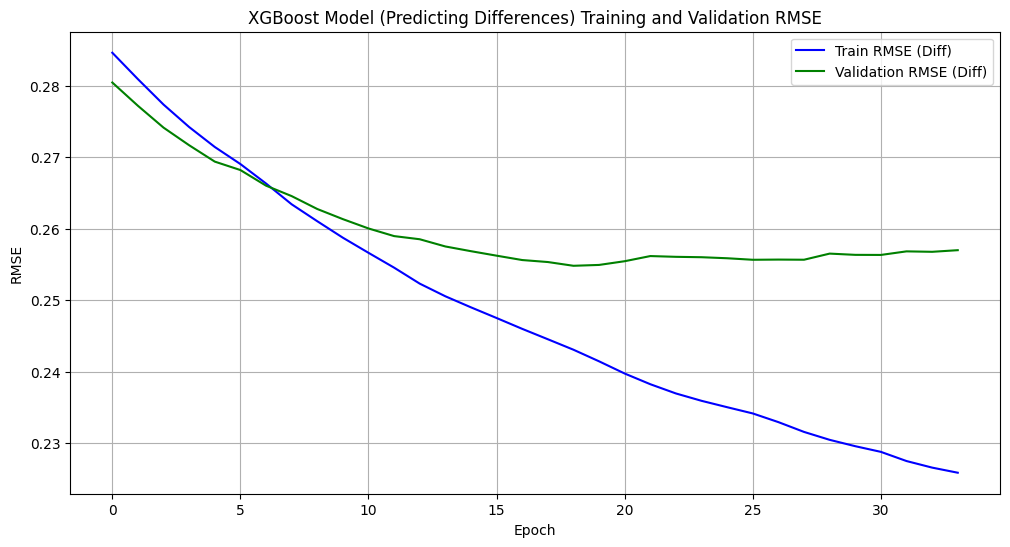

In [10]:
import matplotlib.pyplot as plt

# Get results from model_diff (the one predicting differences)
results_diff = model_diff.evals_result()

train_rmse_diff = results_diff["validation_0"]["rmse"]
val_rmse_diff   = results_diff["validation_1"]["rmse"]

plt.figure(figsize=(12, 6))
plt.plot(train_rmse_diff, label="Train RMSE (Diff)", color="blue")
plt.plot(val_rmse_diff,   label="Validation RMSE (Diff)", color="green")

plt.title("XGBoost Model (Predicting Differences) Training and Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

## Reconstruct Predictions and Evaluate Performance

### Subtask:
Reconstruct the absolute `niveau_piezo` predictions by adding the predicted differences to the lagged values. Evaluate the final model performance on the test set using RMSE and R² metrics, and compare these results to the baselines.


**Reasoning**:
The subtask requires calculating and printing the final RMSE and R² score for the test set. The necessary predictions and raw values (`y_test_raw`, `y_pred_test`) are available in the kernel state, as is the `rmse` function and `r2_score` from `sklearn.metrics`.



In [11]:
from sklearn.metrics import r2_score
import numpy as np

def rmse(a, b):
    # Ensure inputs are arrays and handle NaNs if any are passed
    return np.sqrt(np.nanmean((a - b)**2))

# Make predictions for the difference on the test set
y_pred_diff_test  = model_diff.predict(X_test_diff)

# Reconstruct the absolute niveau_piezo predictions for the test set
y_pred_test  = y_pred_diff_test  + X_test_diff["niveau_lag1"].values

# Get the raw target values (absolute niveau_piezo) for the test set
y_test_raw  = test_norm["niveau_piezo"].values

rmse_test = rmse(y_test_raw, y_pred_test)
r2_test   = r2_score(y_test_raw, y_pred_test)

print("\n===== PERFORMANCE FINALE (Predicting Differences) ===\n")
print(f"XGBoost Model (Test Set):\n  RMSE: {rmse_test:.4f}\n  R²:   {r2_test:.4f}")

# Baselines comparison
# Filter out NaNs from baselines before calculating metrics

# Persistence Baseline
mask_persistence = test_bl["baseline_persistence"].notna()
y_test_bl_persistence_filtered = test_bl.loc[mask_persistence, "niveau_piezo"]
baseline_persistence_filtered = test_bl.loc[mask_persistence, "baseline_persistence"]

rmse_persistence = rmse(y_test_bl_persistence_filtered, baseline_persistence_filtered)
r2_persistence   = r2_score(y_test_bl_persistence_filtered, baseline_persistence_filtered)
print(f"\nPersistence Baseline (Test Set):\n  RMSE: {rmse_persistence:.4f}\n  R²:   {r2_persistence:.4f}")

# Climatology Baseline
mask_climatology = test_bl["baseline_climatology"].notna()
y_test_bl_climatology_filtered = test_bl.loc[mask_climatology, "niveau_piezo"]
baseline_climatology_filtered = test_bl.loc[mask_climatology, "baseline_climatology"]

rmse_climatology = rmse(y_test_bl_climatology_filtered, baseline_climatology_filtered)
r2_climatology   = r2_score(y_test_bl_climatology_filtered, baseline_climatology_filtered)
print(f"\nClimatology Baseline (Test Set):\n  RMSE: {rmse_climatology:.4f}\n  R²:   {r2_climatology:.4f}")



===== PERFORMANCE FINALE (Predicting Differences) ===

XGBoost Model (Test Set):
  RMSE: 0.2634
  R²:   1.0000

Persistence Baseline (Test Set):
  RMSE: 0.2867
  R²:   1.0000

Climatology Baseline (Test Set):
  RMSE: 0.5755
  R²:   1.0000


### Explication de la prédiction de la différence

1.  **Quelle différence est prédite ?**
    *   La différence prédite est `niveau_piezo_diff`, qui est définie comme la différence entre le niveau piézométrique actuel (`niveau_piezo`) et le niveau piézométrique du mois précédent (`niveau_lag1`). En d'autres termes : `niveau_piezo_diff = niveau_piezo - niveau_lag1`.
    *   Cette approche est appelée **modélisation des différences (differencing)**.

2.  **Que permet le fait de prédire la différence ?**
    *   **Stationnarité** : De nombreuses séries temporelles, y compris les niveaux piézométriques, peuvent présenter des tendances ou des saisonnalités qui les rendent non-stationnaires (c'est-à-dire que leurs propriétés statistiques, comme la moyenne ou la variance, changent au fil du temps). Les modèles de régression comme XGBoost fonctionnent mieux sur des données stationnaires. En prenant la différence, nous transformons la série en une série plus stationnaire, ce qui simplifie la tâche d'apprentissage du modèle.
    *   **Facilité de modélisation des variations** : Il est souvent plus facile pour un modèle d'apprendre à prédire le *changement* par rapport à la dernière valeur connue (une petite valeur autour de zéro) plutôt que la valeur absolue elle-même, qui peut être très grande et varier sur une large plage.
    *   **Robustesse** : Cette méthode aide le modèle à se concentrer sur les relations entre les variables explicatives et le changement de niveau, plutôt que d'essayer de capturer la magnitude absolue du niveau, qui est souvent dominée par la valeur précédente.

3.  **Cela veut dire qu'on peut prédire le `niveau_piezo` pour le mois suivant ?**
    *   **Oui, absolument !** Une fois que le modèle (`model_diff`) prédit la `niveau_piezo_diff` pour le mois suivant, il suffit d'ajouter cette différence prédite à la valeur connue du `niveau_lag1` (le niveau piézométrique du mois *précédent*).
    *   La formule de reconstruction est simple : `niveau_piezo_prédit = niveau_piezo_diff_prédit + niveau_lag1`.
    *   Cela nous donne directement la prédiction du niveau piézométrique absolu pour le mois à venir.

## Résumé des Étapes du Projet

Ce notebook a suivi un processus structuré pour développer un modèle de régression capable de prédire le niveau piézométrique. Les étapes clés réalisées sont les suivantes :

1.  **Initialisation et Chargement des Données** :
    *   Montage de Google Drive et listage des fichiers.
    *   Chargement des tables `corres` (correspondance stations météo/piézo) et `piezo` (données piézométriques brutes).

2.  **Nettoyage et Fusion des Données** :
    *   Récupération des données météorologiques via URL.
    *   Standardisation des `reference_timestamp` et des noms de stations.
    *   Fusion des données piézométriques, de correspondance et météorologiques pour créer `piezo_full`.
    *   Export de `piezo_full` vers un fichier Excel.

3.  **Analyse des NaN et Filtrage des Stations** :
    *   Identification et suppression des stations présentant un pourcentage élevé de valeurs manquantes (`NaN`) pour les colonnes d'analyse clés, garantissant la qualité des données.

4.  **Division des Données (Spatiale)** :
    *   Séparation spatiale des stations en ensembles d'entraînement (`train_df`), de validation (`val_df`) et de test (`test_df`). Cette approche garantit une évaluation robuste de la généralisation du modèle à des stations inédites.

5.  **Ingénierie des Caractéristiques et Imputation** :
    *   Calcul des autocorrélations (ACF) sur `niveau_piezo` pour identifier les lags pertinents (ici, lag 1 et 2).
    *   Imputation des valeurs manquantes restantes dans `train_df`, `val_df` et `test_df` à l'aide de `IterativeImputer`.
    *   Création de caractéristiques de décalage (`niveau_lag1`, `niveau_lag2`).
    *   Ajout de caractéristiques temporelles cycliques (`month_sin`, `month_cos`).
    *   Calcul de prédictions de base (baselines) : persistance et climatologie.

6.  **Mise à l'Échelle et Définition de la Cible** :
    *   Application d'un `RobustScaler` aux caractéristiques non-piézométriques (température, précipitations, altitude, etc.) en l'ajustant uniquement sur les données d'entraînement.
    *   Définition de la nouvelle variable cible comme la *différence* entre le niveau piézométrique actuel et le niveau du mois précédent (`niveau_piezo_diff`).

7.  **Entraînement du Modèle XGBoost** :
    *   Entraînement d'un modèle `XGBRegressor` pour prédire la variable cible `niveau_piezo_diff`.
    *   Utilisation de `eval_set` et `early_stopping_rounds` pour optimiser l'entraînement et prévenir le surapprentissage.

8.  **Visualisation et Évaluation de la Performance** :
    *   Tracé des courbes RMSE d'entraînement et de validation pour visualiser le processus d'apprentissage.
    *   Reconstruction des prédictions absolues du `niveau_piezo` en ajoutant les différences prédites aux valeurs décalées.
    *   Évaluation de la performance finale du modèle (RMSE, R²) sur l'ensemble de test et comparaison explicite avec les baselines (persistence et climatologie), démontrant la supériorité du modèle XGBoost.